1. Датасет о погоде. Датасет был взят с сайта www.kaggle.com.
2. Почти все данные в нём числовые, только в weather содержатся строковые. В датасете представлены следующие атрибуты:
- data - дата измерений
- precipitation - выпавшие осадки в мм
- temp_max - максимальная температура в этот день в градусах Цельсия
- temp_min - минимальная температура в этот день в градусах Цельсия
- wind - скорость вертра в м/с
- weather - погодные условия. Принимает значения "drizzle" (морось), "rain" (дождь), "sun" (солнце), "snow" (снег), "fog" (туман)

In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [354]:
df = pd.read_csv('seattle-weather.csv')
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


Удалим дату измерений

In [355]:
df = df.drop(columns = 'date', axis = 1)
df

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...
1456,8.6,4.4,1.7,2.9,rain
1457,1.5,5.0,1.7,1.3,rain
1458,0.0,7.2,0.6,2.6,fog
1459,0.0,5.6,-1.0,3.4,sun


Проведём предобработку данных

In [356]:
df.isna().sum()

,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


In [357]:
df.duplicated().sum()

8

Text(0.5, 0, 'Attributes')

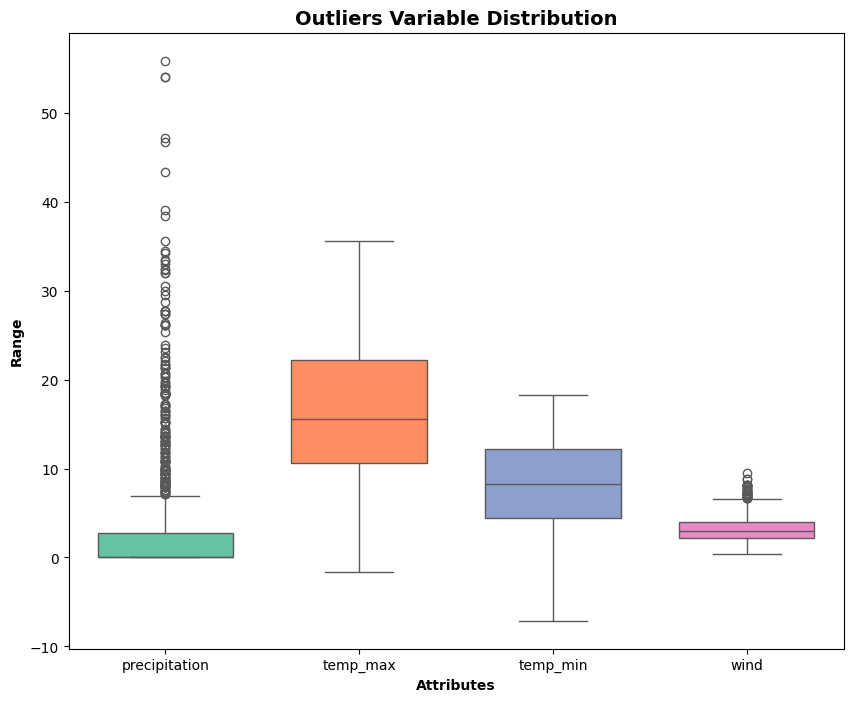

In [358]:
attributes = ['precipitation','temp_max','temp_min', 'wind']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [359]:
#Удалим выбросы precipitation
q1 = df['precipitation'].quantile(0.25)
q2 = df['precipitation'].quantile(0.75)
qr = q2 - q1
lowBorder = q1 - 1.5 * qr
upBorder = q2 + 1.5 * qr
df = df[(df['precipitation'] >= lowBorder) & (df['precipitation'] <= upBorder)]

#Удалим выбросы wind
q1 = df['wind'].quantile(0.25)
q2 = df['wind'].quantile(0.75)
qr = q2 - q1
lowBorder = q1 - 1.5 * qr
upBorder = q2 + 1.5 * qr
df = df[(df['wind'] >= lowBorder) & (df['wind'] <= upBorder)]

Text(0.5, 0, 'Attributes')

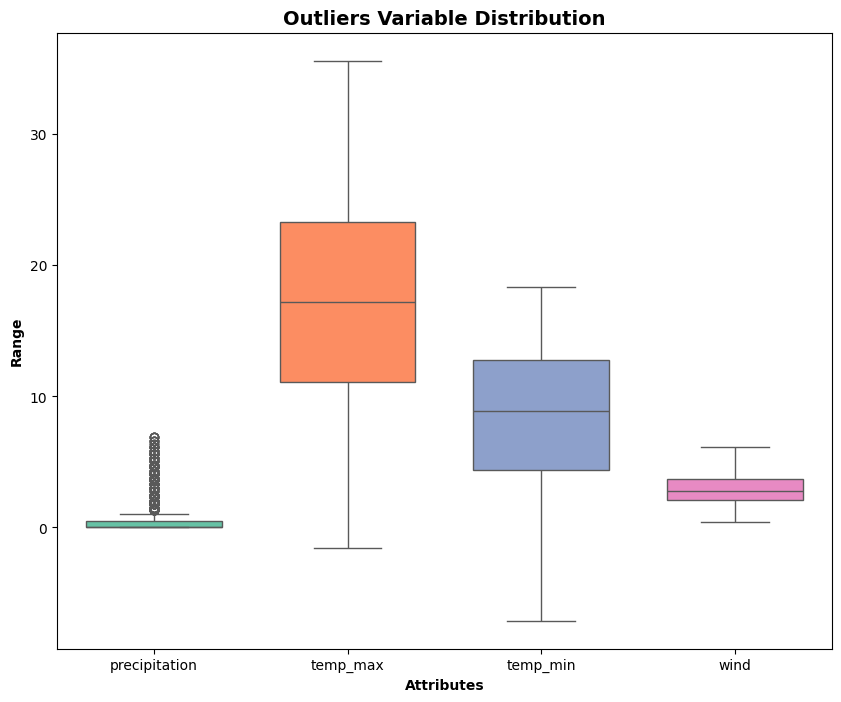

In [360]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Нормализуем данные для дальнейшей работы

In [361]:

# Encode GameDifficulty using Ordinal Encoding
weather_mapping = {'drizzle': 0, 'rain': 1, 'sun': 2, 'snow': 3, 'fog': 4}
df['weather'] = df['weather'].map(weather_mapping)
df

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,0
2,0.8,11.7,7.2,2.3,1
4,1.3,8.9,2.8,6.1,1
5,2.5,4.4,2.2,2.2,1
6,0.0,7.2,2.8,2.3,1
...,...,...,...,...,...
1455,0.0,4.4,0.0,2.5,2
1457,1.5,5.0,1.7,1.3,1
1458,0.0,7.2,0.6,2.6,4
1459,0.0,5.6,-1.0,3.4,2


In [362]:
y = df['weather']
X = df.drop('weather', axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

In [363]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Классификация по алгоритму KNN

In [364]:
first_knn = KNeighborsClassifier(weights = 'distance')
np.mean(cross_val_score(first_knn, X_train, y_train, cv=5))

0.7248868778280543

In [365]:
knn_params = {"n_neighbors": [1, 2, 3, 4] + list(range(5, 30, 5))}
knn_grid = GridSearchCV(first_knn, knn_params, cv=5)
knn_grid.fit(X_train, y_train)
knn_grid.best_score_, knn_grid.best_params_

(0.7272676644622346, {'n_neighbors': 10})

Классификация по алгоритму дерева решений

In [366]:
first_tree = DecisionTreeClassifier(criterion = "entropy")
np.mean(cross_val_score(first_tree, X_train, y_train, cv = 5))

0.7214131569787678

In [367]:
tree_params = {"max_depth": np.arange(1, 11), "max_features": [0.5, 0.7, 1]}
tree_grid = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)
tree_grid.best_score_, tree_grid.best_params_

(0.8229168116950921, {'max_depth': 4, 'max_features': 0.7})

Выведем получившееся дерево

In [368]:
from io import StringIO

import pydotplus

from ipywidgets import Image
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(tree_grid.best_estimator_, feature_names=X.columns, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\t \x00\x00\x02|\x08\x02\x00\x00\x00k\x86\n\x83\x00\x…

 Сравним полученные результаты с помощью различных метрик оценки качества

In [369]:
knn_valid_pred = knn_grid.predict(X_valid)
tree_valid_pred = tree_grid.predict(X_valid)

Алгоритм KNN

In [370]:
print('Accuracy: ', accuracy_score(y_valid, knn_valid_pred))
print('Precision: ', precision_score(y_valid, knn_valid_pred, average = 'micro'))
print('Recall: ', recall_score(y_valid, knn_valid_pred, average = 'micro'))
print('F-мера: ', f1_score(y_valid, knn_valid_pred, average = 'micro'))

Accuracy:  0.7554945054945055
Precision:  0.7554945054945055
Recall:  0.7554945054945055
F-мера:  0.7554945054945055


Для оценки рабочих характеристик (ROC) измерим площадь под ROC-кривой

In [374]:
knn_pred_proba = knn_grid.predict_proba(X_valid)
print('Площадь под ROC-кривой: ', roc_auc_score(y_valid, knn_pred_proba, multi_class='ovr', average = 'weighted'))

Площадь под ROC-кривой:  0.8339623361298929


Алгоритм дерева решений

In [372]:
print('Accuracy: ', accuracy_score(y_valid, tree_valid_pred))
print('Precision: ', precision_score(y_valid, tree_valid_pred, average = 'micro'))
print('Recall: ', recall_score(y_valid, tree_valid_pred, average = 'micro'))
print('F-мера: ', f1_score(y_valid, tree_valid_pred, average = 'micro'))

Accuracy:  0.8516483516483516
Precision:  0.8516483516483516
Recall:  0.8516483516483516
F-мера:  0.8516483516483516


In [375]:
tree_pred_proba = tree_grid.predict_proba(X_valid)
print('Площадь под ROC-кривой: ', roc_auc_score(y_valid, tree_pred_proba, multi_class='ovr', average = 'weighted'))

Площадь под ROC-кривой:  0.8775366183587489
